## Using a Jupyter notebook
<script type="text/x-mathjax-config">
MathJax.Hub.Config({tex2jax: {inlineMath: [['$','$'], ['\\(','\\)']]}});
MathJax.Ajax.config.path["mhchem"] = "https://cdnjs.cloudflare.com/ajax/libs/mathjax-mhchem/3.3.2";
MathJax.Hub.Config({TeX: {extensions: ["[mhchem]/mhchem.js"]}});
</script><script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/MathJax.js?config=TeX-MML-AM_CHTML' async></script>

$\require{mhchem}$This is a Jupyter notebook, that is, a collection of formatted text and live Python code.

Text and code are separated into cells. The active cell is highlighted with a border with a thicker left edge in blue or green. You can activate a different cell by clicking it with the mouse, or you can move up and down with the keyboard arrows.

To run all of the code within the active cell, just press Ctrl and Enter together. `In [*]:` will appear at the top left corner while the code is running, and the `*` will turn into a number once it has finished. Any output from the code will then appear beneath the cell. *If you find at any point one of the text cells (e.g. this one) is no longer nicely formatted, but instead looks like code, just do the same: select it and press Ctrl and Enter to revert back.*

Everything on a line after a `#` is just a comment. We use comment lines with arrows to indicate which parts of the code you are encouraged to modify (although of course, you can try out whatever you like!):

```python
# Don't change this bit (unless you know what you're doing!)
#-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓

# Do edit this section!

#-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑
# Don't edit this part either!
```

Code cells need to be run in the order that they appear in the notebook, as the later cells depend on the results of calculations from earlier cells.

---

# Pitzer modelling with Pytzer

This tutorial is intended as an extension to the web-based MarChemSpec model demonstrations, which use an underlying Pitzer model implemented in Fortran: [aim.env.uea.ac.uk/osm/main_page.html](http://www.aim.env.uea.ac.uk/osm/main_page.html). Here, we use [Pytzer](https://github.com/mvdh7/pytzer) instead, a Python implementation of the Pitzer model.

If you'd like to find out more, or use Pytzer in your work, it has its own [detailed documentation](https://pytzer.readthedocs.io/en/latest/). This includes installation instructions and also illustrates some simple example workflows.

## Setting the solution composition and conditions

Pytzer requires the solution's **composition** and **conditions** as inputs. The composition details the types of solutes that are present, along with their molality. Note that this is a "true" molality, in mol/kg-H<sub>2</sub>O, rather than the mol/kg-seawater more commonly used by marine chemists. The conditions are the solution's temperature and pressure.

The following code example shows how to import Pytzer and the other Python packages needed for this demonstration, then how to define the various inputs required by Pytzer in the appropriate format. The composition defined here is then used again in the subsequent code sections. If you modify anything in this first code block, remember that you need to re-evaluate it with Ctrl and Enter before the changes will take effect in the later code blocks.

### Things to try:

> **Evaluate the code cell below** (by selecting it then pressing Ctrl and Enter together).
>
> You will see the solution composition that you have defined printed out underneath.

In [1]:
# Import the packages that we will need
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib notebook
import pytzer as pz
#-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓

# Define major ion molalities in mol/kg-H2O
solutes = {
    'Na': 0.4860597,
    'Mg': 0.0547421,
    'Ca': 0.0106568,
    'K': 0.0105797,
    'Cl': 0.5657647,
    'SO4': 0.0292643,
    'H': 10.0**-8.1, # i.e. p[H+] = 8.1
}

# Define the solution conditions
tempK = np.array([
    298.15, # temperature in K
])
pres = np.array([
    10.10325, # pressure in dbar (here, 1 atm)
])
# ^ pressure includes atmospheric pressure, unlike typical water column measurements

#-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑
# Calculate OH- molality from charge balance and check it's positive
solutes['OH'] = (solutes['Na'] + 2*solutes['Mg'] + 2*solutes['Ca'] + solutes['K']
                 - solutes['Cl'] - 2*solutes['SO4'] - solutes['H'])
if solutes['OH'] < 0:
    print()
    print('Warning: charge balance gives negative OH- molality!')
    print()
    
# If OH- molality is positive, then on with the show
else:
    # Reformat the solutes dict into the inputs required by Pytzer
    mols = np.vstack([solutes[solute] for solute in solutes.keys()])
    ions = np.array([solute for solute in solutes.keys()])

    # Print out the conditions that we've set up
    print('Solution composition:')
    for i, ion in enumerate(ions):
        print('  [{:3}] = {:.4e} mol/kg-H2O'.format(ion, mols[i][0]))
    print('Temperature = {} K'.format(tempK[0]))
    print('Pressure = {} dbar'.format(pres[0]))

Solution composition:
  [Na ] = 4.8606e-01 mol/kg-H2O
  [Mg ] = 5.4742e-02 mol/kg-H2O
  [Ca ] = 1.0657e-02 mol/kg-H2O
  [K  ] = 1.0580e-02 mol/kg-H2O
  [Cl ] = 5.6576e-01 mol/kg-H2O
  [SO4] = 2.9264e-02 mol/kg-H2O
  [H  ] = 7.9433e-09 mol/kg-H2O
  [OH ] = 3.1439e-03 mol/kg-H2O
Temperature = 298.15 K
Pressure = 10.10325 dbar


## Calculate solution properties with Pytzer

The next step is to use Pytzer to calculate some properties of the solution defined above. In the example below, we first choose which set of Pitzer model interaction parameters we want to use. By default, we use the set recommended by the MarChemSpec project, but [other options](https://pytzer.readthedocs.io/en/latest/modules/parameters/) are built in to Pytzer, and you can modify these or even [construct your own](). Each specific combination of parameters that we can use is called a "parameter library" or `prmlib`.

Then, below we can calculate the **water activity**, `aw` and the **solute activity coefficients** for all solutes, `acfs`. We choose one of the solutes, `ionX`, for which to extract the activity coefficient and compute the activity.

### Things to try:

> **Evaluate the cell below** (once you have first evaluated the cell above). You will see the calculated activities underneath.
>
> Next, you can **change which ion to show results for**, by adjusting the value of `ionX` below.
>
> You could **repeat the calculation for a different solution**, by modifying the `solutes` molalities listed above, and then re-evaluating both code cells.

In [2]:
# Choose our Pitzer model parameter library (prmlib)
prmlib = deepcopy(pz.libraries.MarChemSpec)
prmlib.add_zeros(ions) # fills in any missing interaction parameters with zeros

# Calculate the water activity (aw)
aw = pz.model.aw(mols, ions, tempK, pres, prmlib)

# Calculate all solute activity coefficients (acfs)
acfs = pz.model.acfs(mols, ions, tempK, pres, prmlib)
#-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓

# Choose an ion to show results for, from entries in solutes
# i.e. 'Na', 'Mg', 'Ca', 'K', 'Cl', 'SO4', 'H' or 'OH':
ionX = 'H'

#-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑
# Pull out the chosen ion's activity coefficient (acfX), input molality (mX) and calculate its activity (aX)
acfX = acfs[ions == ionX][0][0]
mX = mols[ions == ionX][0][0]
aX = acfX*mX

# Display the results
print('Water activity in the solution = {:.5f}'.format(aw[0]))
print('{} ion:'.format(ionX))
print('         Molality = {:.5e} mol/kg-H2O'.format(mX))
print('  Activity coeff. = {:.5f}'.format(acfX))
print('         Activity = {:.5e}'.format(aX))

Water activity in the solution = 0.98129
H ion:
         Molality = 7.94328e-09 mol/kg-H2O
  Activity coeff. = 0.73275
         Activity = 5.82043e-09


## Test how changing temperature affects activities

We can use Pytzer to calculate solution properties for multiple different compositions or conditions at once. For example, here we investigate how changing temperature affects the activity of each ion in the same solution defined above.

### Things to try:

> **Evaluate the cell below**. You should see a plot of the effect of changing temperature from 0 to 50 °C on the activity of the hydrogen ion.
>
> **Visualise the activity of a different solute** by changing the value of the `ionX_v` variable.
> 
> **Change the set of input temperatures to test** by adjusting the `tempK_v` variable following the instructions given in the comments.
>
> **Try again with a different solution composition** by modifying the `solutes` variable in the first code cell in this tutorial.

<IPython.core.display.Javascript object>


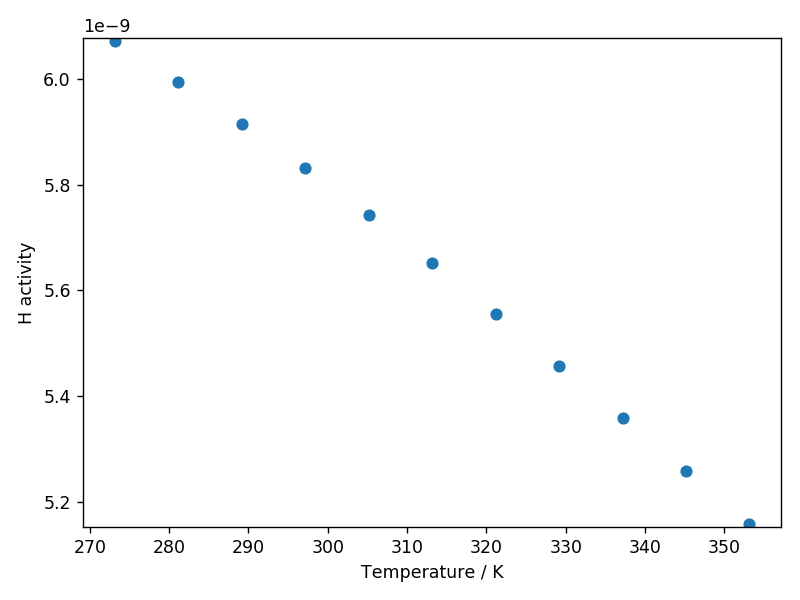

In [3]:
#-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓-↓

# Set temperatures to test:
tempK_v = np.linspace(273.15, 353.15, 11)
# ^ np.linspace(A, B, C) selects C evenly spaced points from A to B inclusive
# e.g. np.linspace(273.15, 323.15, 11) generates 11 evenly spaced points from 273.15 to 323.15 K

# Choose an ion to plot results for, from entries in solutes
# i.e. 'Na', 'Mg', 'Ca', 'K', 'Cl', 'SO4', 'H' or 'OH':
ionX_v = 'H'

#-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑-↑

# Use other molalities from the solutes dict and reformat for Pytzer
mols_v = np.array([np.full(np.size(tempK_v), solutes[solute]) for solute in solutes.keys()])
pres_v = np.full(np.size(tempK_v), pres)

# Calculate all solute activity coefficients (acfs)
acfs_v = pz.model.acfs(mols_v, ions, tempK_v, pres_v, prmlib)

# Pull out the chosen ion's activity coefficient (acfX), input molality (mX) and calculate its activity (aX)
acfX_v = acfs_v[ions == ionX_v][0]
mX_v = mols_v[ions == ionX_v][0]
aX_v = acfX_v*mX_v

# Plot the calculated activity against input temperature
fig, ax = plt.subplots()
ax.scatter(tempK_v, aX_v)
ax.set_xlabel('Temperature / K')
ax.set_ylabel('{} activity'.format(ionX_v))
ax.set_ylim([0.999*np.min(np.abs(aX_v)), 1.001*np.max(np.abs(aX_v))])
plt.tight_layout()

## What about equilibria?

Pytzer does include [a module that can solve for equilibrium](https://pytzer.readthedocs.io/en/latest/modules/equilibrate/). However, only a small subset of the reactions in seawater are currently included, and the overall solving approach will probably be substantially revised as development continues. Of course, you're welcome to try it out, but for now we recommend that you use the [web-based Fortran tools](http://www.aim.env.uea.ac.uk/osm/main_page.html) for equilibrium calculations.

## What about uncertainties?

Although uncertainties in the Pitzer model parameters and thermodynamic equilibrium constants can in principle be propagated with Pytzer, there's no built-in generic method for this yet. Again, we recommend the [web-based Fortran tools](http://www.aim.env.uea.ac.uk/osm/main_page.html) if you'd like to try out these calculations yourself.

## Comments and questions

If you have any comments or questions about Pytzer, then please do get in touch: [mvdh.xyz/contact](https://mvdh.xyz/contact)

For more general queries about Pitzer modelling and the MarChemSpec project, see its website: [marchemspec.org](http://marchemspec.org)